In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
plt.style.use("ggplot")


$$
\frac{x^2}{a^2} + \frac{y^2}{b^2} = 1
$$

In [4]:
c = 300000 # km/s
lightning_pt = (-250, 100)
lls_1 = (-250, 0)
lls_2 = (250,0)
delta_t = calc_distance(lls_1, lightning_pt) /c - calc_distance(lls_2, lightning_pt) /c

In [5]:
def calc_distance(X1, X2):
    dist = np.sqrt(
        (X1[0] -X2[0])**2 + (X1[1]- X2[1])**2
    )
    return dist

In [6]:
delta_t

# 
a = np.abs((c * delta_t) /2)  
b = np.sqrt(lls_1[0]**2 - a**2)

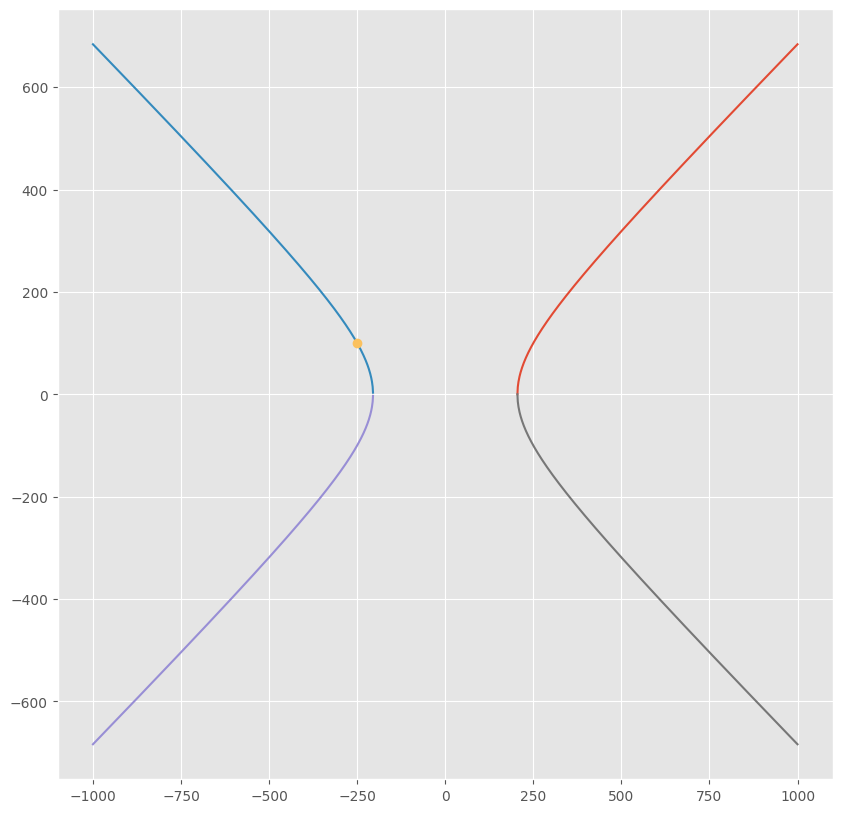

In [7]:

x_minus  = np.arange(-1000, -np.abs(a),1) 
x_plus = np.arange(np.abs(a), 1000, 1)

y_1 = (b/a) * np.sqrt(x_plus**2 - a**2)
y_2 = (b/a) * np.sqrt(x_minus**2 - a**2)
y_3 = (-b/a) * np.sqrt(x_minus**2 - a**2) 
y_4 = (-b/a) * np.sqrt(x_plus**2 - a**2)

fig , ax =plt.subplots(figsize=(10,10))
ax.plot(x_plus, y_1)
ax.plot(x_minus, y_2)
ax.plot(x_minus, y_3)
ax.plot(x_plus, y_4)
ax.plot(*lightning_pt, marker="o")


In [8]:
theta = np.deg2rad(30)
A = np.array(
    [
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ]
)


In [9]:
np.dot(
    A , np.array( (x_plus[0], y_1[0])).T
      )

array([177.49275147, 102.47548784])

In [10]:
def rotation(deg, x, y):
    theta = np.deg2rad(deg)
    A = np.array(
        [
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ]
    )
    rot_x = x * np.cos(theta) - y* np.sin(theta)
    rot_y = x * np.sin(theta) + y*np.cos(theta)
    return rot_x, rot_y

In [11]:
rotation(30,)

TypeError: rotation() missing 2 required positional arguments: 'x' and 'y'

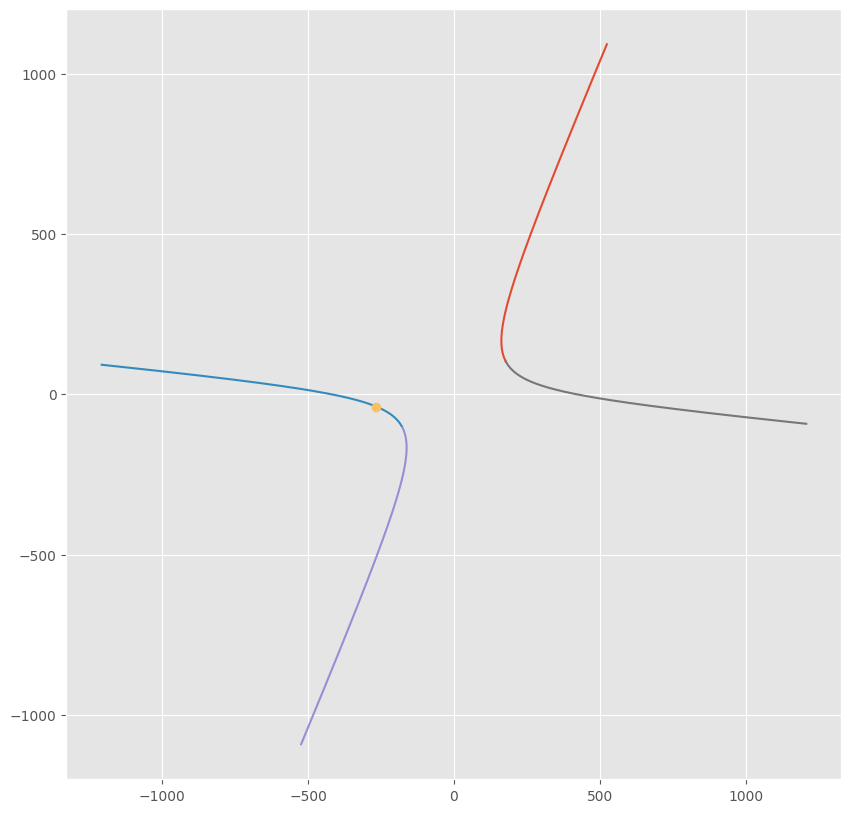

In [12]:
deg =30
x_minus  = np.arange(-1000, -np.abs(a),1) 
x_plus = np.arange(np.abs(a), 1000, 1)

y_1 = (b/a) * np.sqrt(x_plus**2 - a**2)
y_2 = (b/a) * np.sqrt(x_minus**2 - a**2)
y_3 = (-b/a) * np.sqrt(x_minus**2 - a**2) 
y_4 = (-b/a) * np.sqrt(x_plus**2 - a**2)

fig , ax =plt.subplots(figsize=(10,10))
ax.plot(*rotation(deg, x_plus, y_1))
ax.plot(*rotation(deg, x_minus, y_2))
ax.plot(*rotation(deg, x_minus, y_3))
ax.plot(*rotation(deg, x_plus, y_4))
ax.plot(*rotation(deg, *lightning_pt), marker="o")

# いよいよ実装していく
## 前提条件

* 地球の曲率は考えないこととする
* そのために到達時刻が一番近いLLS上位3~4で位置同定を行うこととする
* 緯度経度差は等間隔だと仮定し、オイラ座標で考える

## 手順 

1. LLS2地点A(x1,y1),B(x2,y2)の中点を原点Oとしてy軸が2地点の線分の法線となる座標系を考える
2. ABの中点((x1+x2)/2, (y1+y2)/2)が原点OとなるようにABを平行移動する
3. A,Bのy座標が0となるように各点をγ回転する、この時tan(γ) = -(y1-y2)/(x1-x2)
5. 2地点の到達時間差delta_tを求めて、1の座標系における時間差delta_tを満たす双曲線の頂点(a,0),(-a,0)を求める
6. 双曲線の関係から$c^2 = a^2 + b^2$よりbを求める。
7. 双曲線を描くための配列を生成する
8. 7で作った配列を-γ回転して、原点Oが元のABの中点に戻るまで平行移動する


In [181]:

def get_M(a,b):
    m = (a + b) / 2.0
    return m

def shift_to_O(a, m):
    a0 = a - m
    return a0
    
def calc_rot_gamma(a,b ):
    gamma = np.arctan( -(a[1]- b[1])/(a[0]-b[0]))
    return gamma

def rotation(gamma, X0):
    rot_x = X0[0] * np.cos(gamma) - X0[1]* np.sin(gamma)
    rot_y = X0[0] * np.sin(gamma) + X0[1]*np.cos(gamma)
    rotX = np.array((rot_x, rot_y))
    return rotX
    


# 頂点alphaを求める(本来ここは観測で得られるものだが一旦ダミーなので)
def calc_alpha(rot_a, rot_b, rot_lt):
    alpha = 0.5* ( 
        np.sqrt(
            (rot_a[0]-rot_lt[0])**2 + (rot_a[1]-rot_lt[1])**2 
        )
        -np.sqrt(
            (rot_b[0]-rot_lt[0])**2 + (rot_b[1] -rot_lt[1])**2 
        )
    )
    return alpha 

def calc_alpha_from_delat_t(delta_t):
    c=3.0e8
    return 0.5*c*delta_t
    

def calc_beta(rot_a, alpha):
    beta = np.abs(np.abs(rot_a[0])**2 - alpha**2)**0.5 
    return beta

def generate_hyper(alpha, beta):
    x_minus  = np.linspace(-50, -np.abs(alpha), 100) 
    x_plus = np.linspace(np.abs(alpha), 50.1, 100)
    y_1 = (beta/alpha) * np.sqrt(x_plus**2 - alpha**2)
    y_2 = (beta/alpha) * np.sqrt(x_minus**2 - alpha**2)
    y_3 = (-beta/alpha) * np.sqrt(x_minus**2 - alpha**2) 
    y_4 = (-beta/alpha) * np.sqrt(x_plus**2 - alpha**2)   
    return (x_plus, y_1), (x_minus, y_2), (x_minus, y_3), (x_plus, y_4)
    
def rotation_vector(gamma, X,Y):
    X_rot = X*np.cos(gamma) - Y * np.sin(gamma)
    Y_rot = X*np.sin(gamma) + Y*np.cos(gamma)
    return X_rot, Y_rot

def shift_vector(X,Y,m):
    X_shift = X + m[0]
    Y_shift = Y + m[1]
    return X_shift, Y_shift


def decide_lightning_hyperbola(a,b, delta_t):
    
    # abの中点が原点になるように平行移動
    a0 =  shift_to_O(a,m)
    b0 =  shift_to_O(b,m)
    
    # 焦点のy座標が０になるように回転させる
    gamma = calc_rot_gamma(a0, b0)
    rot_a = rotation(gamma, a0)
    rot_b = rotation(gamma, b0)
    
    # 双曲線のパラメータを求める
    alpha = calc_alpha_from_delat_t(delta_t)
    beta = calc_beta(rot_a, alpha)
    
    # 双曲線配列を生成
    z1,z2, z3, z4 = generate_hyper(alpha, beta)
    
    # 双曲線を元の位置に回転する
    z1_rot = rotation_vector(-gamma, z1[0], z1[1])
    z2_rot = rotation_vector(-gamma, z2[0], z2[1])
    z3_rot = rotation_vector(-gamma, z3[0], z3[1])
    z4_rot = rotation_vector(-gamma, z4[0], z4[1])
    
    # 双曲線を元の位置に平行移動する
    z1_shift = shift_vector(z1_rot[0], z1_rot[1], m)
    z2_shift = shift_vector(z2_rot[0], z2_rot[1], m)
    z3_shift = shift_vector(z3_rot[0], z3_rot[1], m)
    z4_shift = shift_vector(z4_rot[0], z4_rot[1], m)

    return (z1_shift, z2_shift, z3_shift, z4_shift)

        
    


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [150]:
calc_rot_gamma(a0,b0)

np.float64(-0.049958395721942765)

In [151]:
lt0

array([0. , 9.5])

In [152]:
a = np.array((120,30))
b = np.array((140, 31))
lt = np.array((130,40))

m = get_M(a,b)
a0 =  shift_to_O(a,m)
b0 =  shift_to_O(b,m)
lt0 = shift_to_O(lt,m)
gamma = calc_rot_gamma(a0, b0)

rot_a = rotation(gamma, a0)
rot_b = rotation(gamma, b0)
rot_lt = rotation(gamma,lt0 )

alpha = calc_alpha(rot_a, rot_b, rot_lt)
beta = calc_beta(rot_a, alpha)
# 双曲線配列を生成
z1,z2, z3, z4 = generate_hyper(alpha, beta)

# 双曲線を元の位置に回転する
z1_rot = rotation_vector(-gamma, z1[0], z1[1])
z2_rot = rotation_vector(-gamma, z2[0], z2[1])
z3_rot = rotation_vector(-gamma, z3[0], z3[1])
z4_rot = rotation_vector(-gamma, z4[0], z4[1])

# 双曲線を元の位置に平行移動する
z1_shift = shift_vector(z1_rot[0], z1_rot[1], m)
z2_shift = shift_vector(z2_rot[0], z2_rot[1], m)
z3_shift = shift_vector(z3_rot[0], z3_rot[1], m)
z4_shift = shift_vector(z4_rot[0], z4_rot[1], m)



In [153]:
m

array([130. ,  30.5])

(-20.0, 20.0)

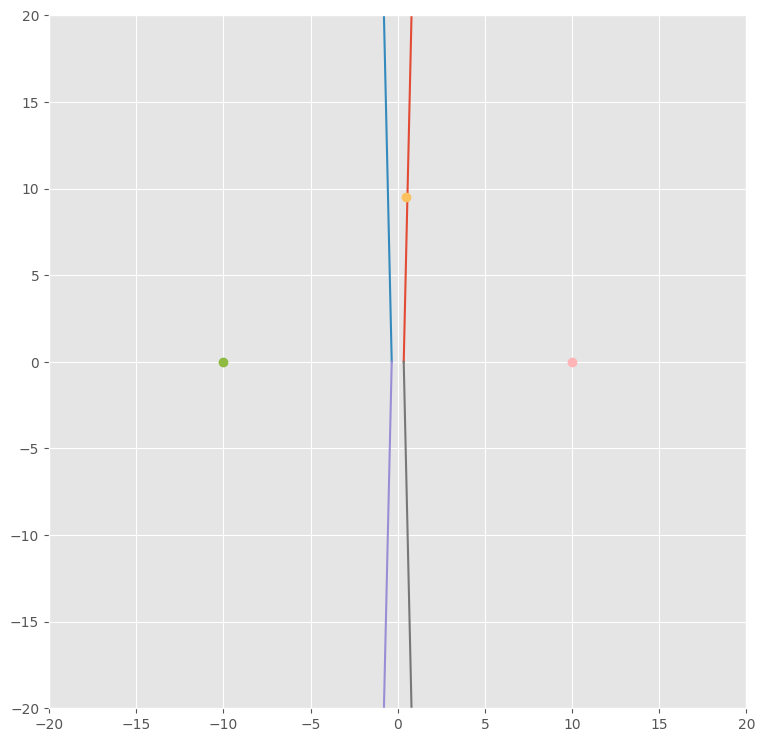

In [157]:
fig, ax = plt.subplots(figsize=(9,9))
ax.plot(*z1)
ax.plot(*z2)
ax.plot(*z3)
ax.plot(*z4)
ax.plot(rot_lt[0], rot_lt[1], marker="o")
ax.plot(rot_a[0], rot_a[1], marker="o")
ax.plot(rot_b[0], rot_b[1], marker="o")
# ax.plot(lt[0], lt[1], marker="o")
ax.set_xlim(-20, 20)
ax.set_ylim(-20,20)

(20.0, 50.0)

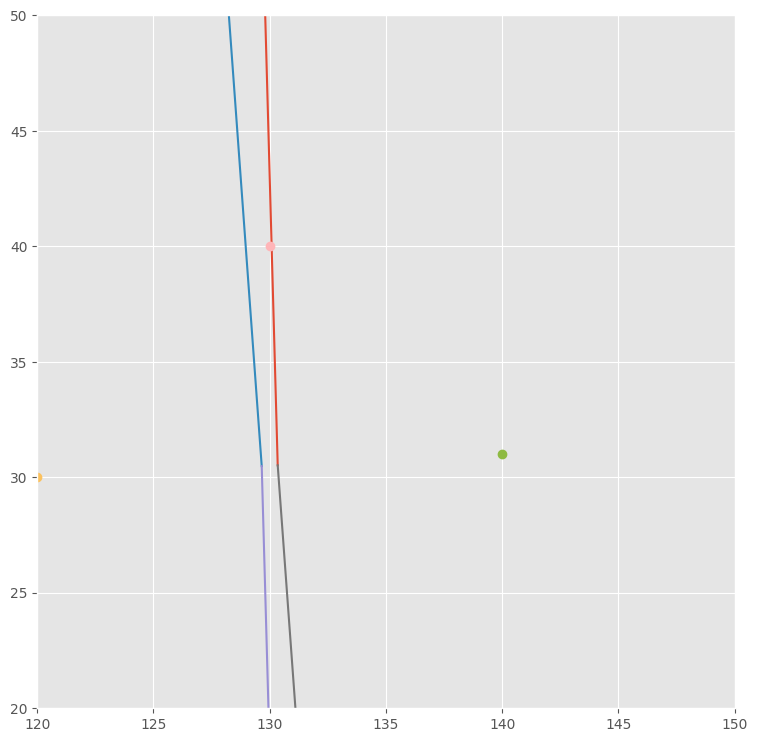

In [158]:
fig, ax = plt.subplots(figsize=(9,9))
ax.plot(*z1_shift)
ax.plot(*z2_shift)
ax.plot(*z3_shift)
ax.plot(*z4_shift)
ax.plot(a[0], a[1], marker="o")
ax.plot(b[0], b[1], marker="o")
ax.plot(lt[0], lt[1], marker="o")
ax.set_xlim(120, 150)
ax.set_ylim(20,50)

In [160]:
## LLS point

In [163]:
df = pd.read_csv("../src/lightning_obs_station.csv")
df

,No,stname,publisher,lat,lon
0,1,NOTO,CEP,37.304944,137.148550
1,2,NIIGATA,CEP,37.957261,139.106270
2,3,NAGANO,CEP,36.628150,138.209236
3,4,SAKU,CEP,36.268473,138.465131
4,5,TAKAYAMA,CEP,36.146823,137.247496
5,6,NAKATSUGAWA,CEP,35.488627,137.490624
6,7,OOGAKI,CEP,35.334437,136.555455
7,8,UENO,CEP,34.772419,136.133563
8,9,ATSUMI,CEP,34.652743,137.150765
9,10,SIMADA,CEP,34.829511,138.171060


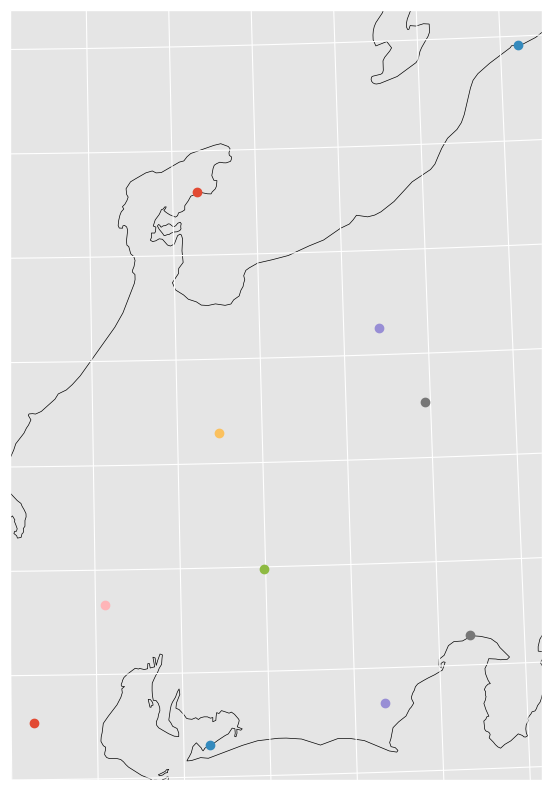

In [164]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection=ccrs.AzimuthalEquidistant(central_longitude=135, central_latitude=35))
ax.gridlines()
ax.coastlines()
for lat, lon in zip(df["lat"], df["lon"]):
    ax.plot(lon,lat, marker="o", transform=ccrs.PlateCarree())

In [ ]:
# 雷から最も近い3地点について双曲線を描画するプログラムを作る

1. 日本近辺で乱数で落雷地点を決める
2. 光速で同心円状に伝播すると仮定して、各地点の到達時刻を計算する　

In [169]:
def generate_lightning():
    lon = np.random.uniform(low=132,high=140, size=1)
    lat = np.random.uniform(low=32, high=40, size=1,)
    return (lon,lat) 

def calculate_arrival_time(df, lightning_lon, lightning_lat):
    c= 3.0e8
    arrive_times = np.sqrt(
        (df["lon"]- lightning_lon)**2
        +(df["lat"]- lightning_lat)**2
    )/c
    return arrive_times




In [170]:
lt_lon, lt_lat = generate_lightning()

In [172]:
df["arrive_time"] = calculate_arrival_time(df, lt_lon, lt_lat)

In [176]:
df_sort = df.sort_values("arrive_time").head(3).reset_index(drop=True)

In [180]:
l = df_sort.iloc[0][["lon","lat"]].to_numpy()
m = df_sort.iloc[1][["lon","lat"]].to_numpy()
n = df_sort.iloc[2][["lon","lat"]].to_numpy()



array([np.float64(136.1335626), np.float64(34.77241864)], dtype=object)